In [1]:
from src.toy_functions import ResponseFunction, six_curve_sum
import torch
from ax import Client, RangeParameterConfig

from torch._tensor import Tensor
import importlib


from botorch.models import SingleTaskGP
import math
import importlib

from src import GPVisualiser, ax_helper
from botorch.models import SingleTaskGP
importlib.reload(GPVisualiser)


<module 'src.GPVisualiser' from 'c:\\GitHub\\BO-Coli\\src\\GPVisualiser.py'>

In [2]:
dim_names = ['x1', 'x2']
simple_func = lambda x: sum(torch.sqrt(x))
resp = ResponseFunction(simple_func, len(dim_names))
resp.evaluate(torch.tensor([1., 4]))

tensor(3.)

In [3]:
from typing import Literal
import pandas as pd
import seaborn as sns


from src.ax_helper import get_guess_coords

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

[INFO 09-17 17:45:13] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-17 17:45:13] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-17 17:45:13] ax.api.client: Generated new trial 1 with parameters {'x0': 3.692029, 'x1': 1.889584} using GenerationNode Sobol.
[INFO 09-17 17:45:13] ax.api.client: Generated new trial 2 with parameters {'x0': 73.84055, 'x1': 38.895377} using GenerationNode Sobol.
[INFO 09-17 17:45:13] ax.api.client: Generated new tria

   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0   3.692029   1.889584
2         2_0  73.840550  38.895377
3         3_0  15.066840   4.782394
4         4_0   2.433668  30.575413
5         5_0   1.158248   6.579127
6         6_0  23.532443  10.073028
7         7_0  47.400097   1.687798
8         8_0   7.742853  83.201719
9         9_0   6.067654   3.803369
10       10_0  33.683528  18.638435
11       11_0  28.610246   3.155978
12       12_0   1.710519  48.036349
13       13_0   1.929917   1.030006
14       14_0  10.593815  66.688744
15       15_0  91.153180   8.061724
16       16_0   5.364656  16.805856
17       17_0   4.738126   9.231552
18       18_0  77.399464  14.154176
19       19_0  11.586065   1.290694
20       20_0   2.354004  63.714487
21       21_0   1.507038   2.388823
22       22_0  24.342937  49.324901
23       23_0  36.913561   3.509165
24       24_0   7.382806  22.504327
25       25_0   9.116980   1.396737
26       26_0  53.655632  90

<Axes: xlabel='x0', ylabel='x1'>

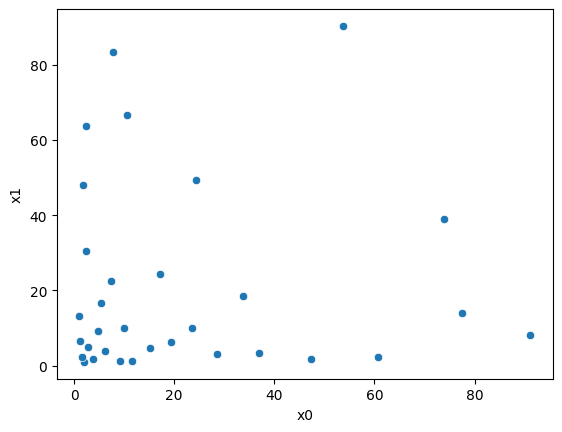

In [4]:
client = Client()

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)


client.configure_optimization(objective="-loss")

client.get_next_trials(max_trials=32)

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

[INFO 09-17 17:45:13] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-17 17:45:13] ax.api.client: Generated new trial 0 with parameters {'x1': 50.5, 'x2': 50.5} using GenerationNode CenterOfSearchSpace.
[INFO 09-17 17:45:13] ax.api.client: Generated new trial 1 with parameters {'x1': 51.285292, 'x2': 65.844596} using GenerationNode Sobol.
[INFO 09-17 17:45:13] ax.api.client: Generated new trial 2 with parameters {'x1': 13.810478, 'x2': 47.859283} using GenerationNode Sobol.
[INFO 09-17 17:45:13] ax.api.client: Generated new t

  trial_name         x1         x2
0        0_0  50.500000  50.500000
1        1_0  51.285292  65.844596
2        2_0  13.810478  47.859283
3        3_0  39.008402  77.801477
4        4_0  75.804901  10.328357
5        5_0  93.957706  97.205090
6        6_0  33.205675  15.798000
7        7_0   7.258581  60.532185
8        8_0  70.235614  28.637097
9        9_0  63.113711  82.765728


<Axes: xlabel='x1', ylabel='x2'>

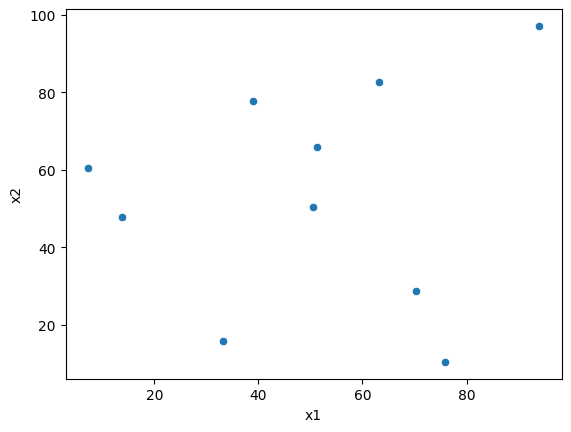

In [5]:


client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)


client.configure_optimization(objective="response")

client.get_next_trials(max_trials=10)




for i, trial in ax_helper.get_obs_from_client(client, response_col='response').iterrows():
    if not pd.isna(trial['response']):
        continue

    response = resp.evaluate(trial[dim_names])
    client.complete_trial(trial_index=i, raw_data={"response": float(response)})

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

[INFO 09-17 17:46:38] ax.api.client: Trial 23 marked COMPLETED.


[INFO 09-17 17:46:38] ax.api.client: Trial 24 marked COMPLETED.
[INFO 09-17 17:46:38] ax.api.client: Trial 25 marked COMPLETED.
[INFO 09-17 17:46:38] ax.api.client: Trial 26 marked COMPLETED.
[INFO 09-17 17:46:38] ax.api.client: Trial 27 marked COMPLETED.
[INFO 09-17 17:46:38] ax.api.client: Trial 28 marked COMPLETED.
[WARNING 09-17 17:46:44] ax.generation_strategy.generation_node: gen failed with error GenerationStrategy exceeded `MAX_GEN_ATTEMPTS` of 5 while trying to generate a unique parameterization. This indicates that the search space has likely been fully explored, or that the sweep has converged., switching to fallback model with generator_enum Generators.SOBOL
[INFO 09-17 17:46:44] ax.api.client: Generated new trial 29 with parameters {'x1': 66.640117, 'x2': 90.99322} using GenerationNode MBM.
[INFO 09-17 17:46:44] ax.api.client: Generated new trial 30 with parameters {'x1': 7.06079, 'x2': 45.983698} using GenerationNode MBM.
[INFO 09-17 17:46:44] ax.api.client: Generated new

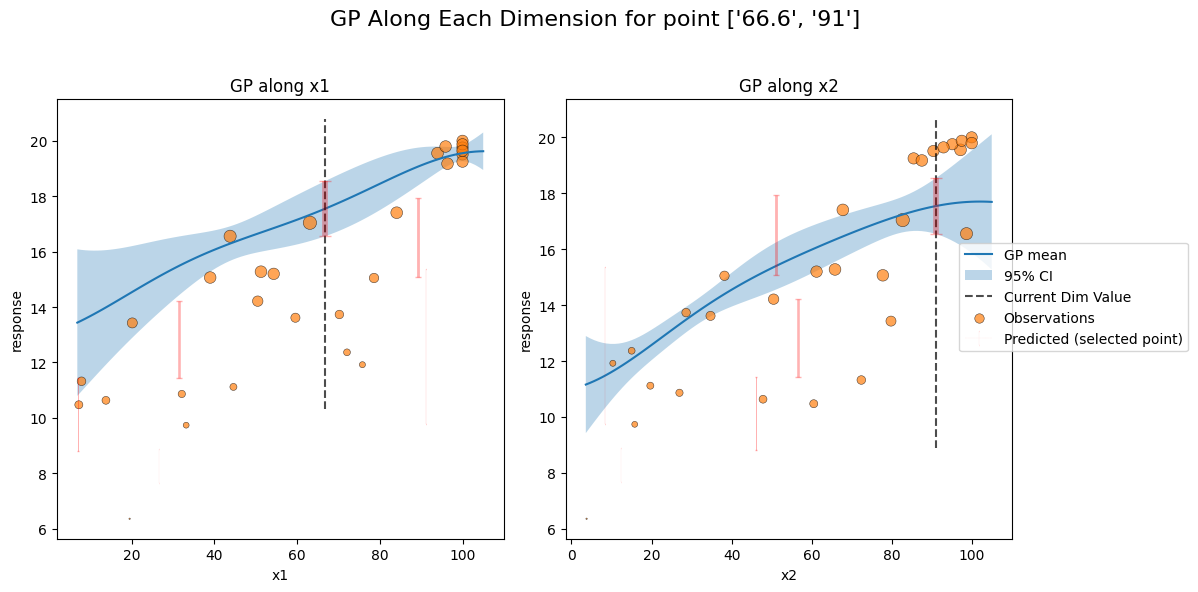

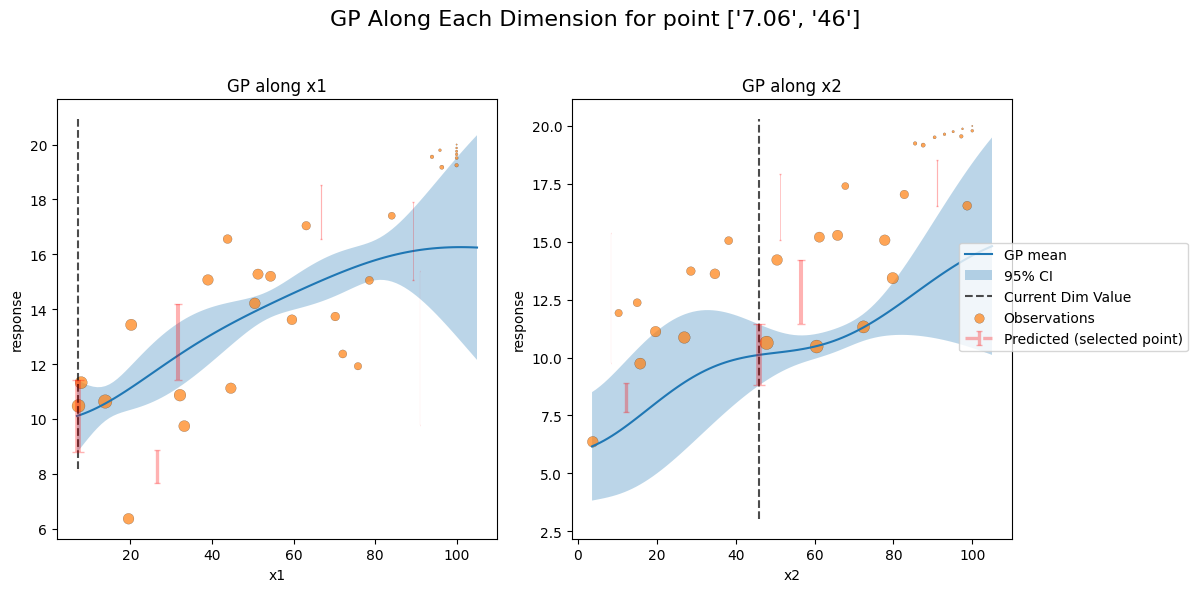

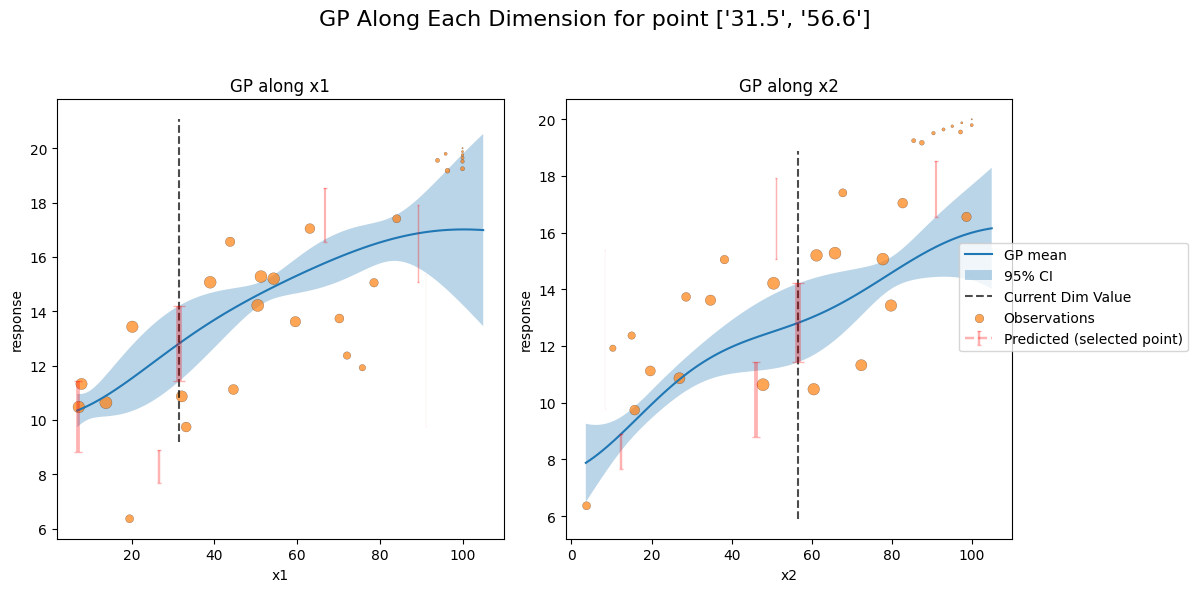

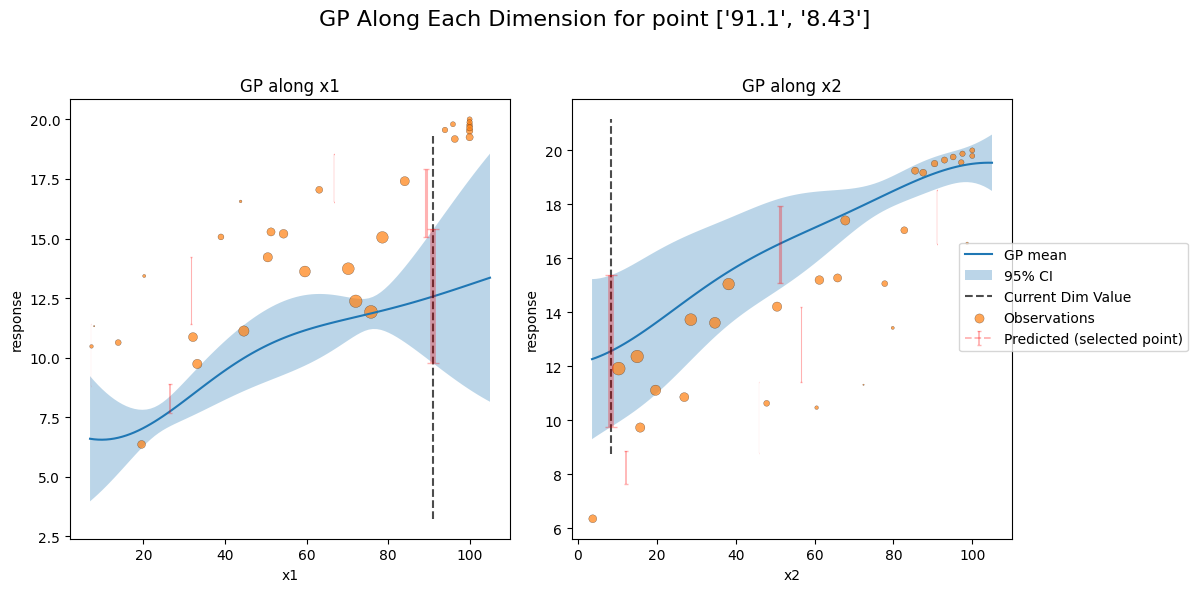

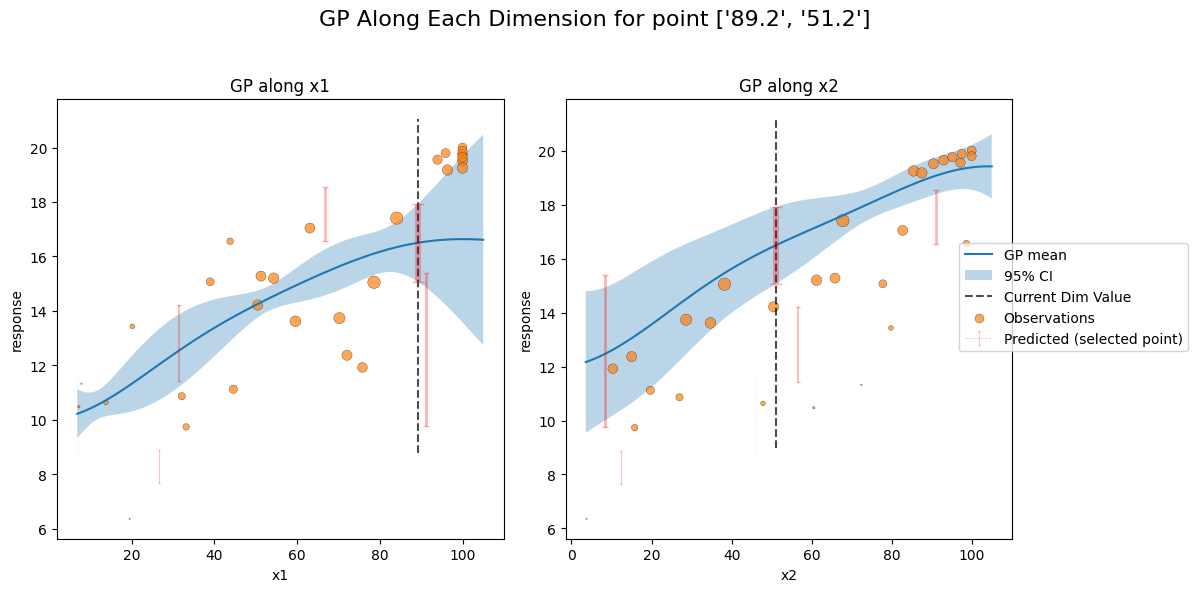

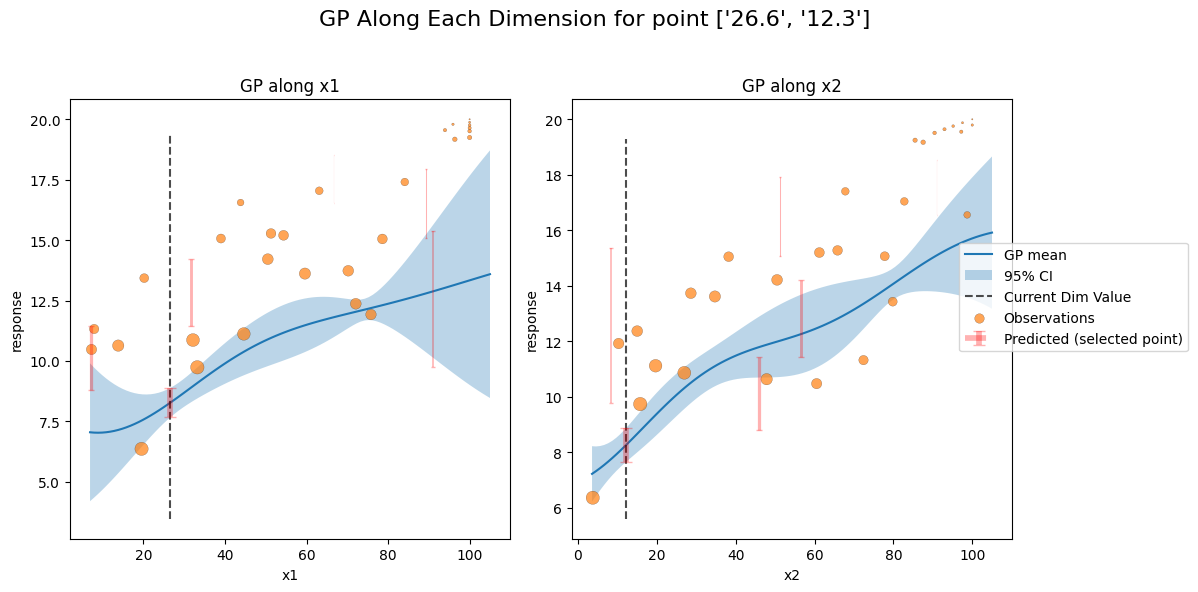

In [10]:


for i, trial in ax_helper.get_obs_from_client(client, response_col='response').iterrows():
    if not pd.isna(trial['response']):
        continue

    response = resp.evaluate(trial[dim_names])
    client.complete_trial(trial_index=i, raw_data={"response": float(response)})

client.get_next_trials(max_trials=6)

obs = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, dim_names, 'response', parameters)


for i, trial in obs.iterrows():
    if pd.isna(trial['response']):

        coords = trial.loc[dim_names]

        plotter.plot_all(torch.tensor(coords))




In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Custom Botorch model

In [ ]:
from ax.generation_strategy.center_generation_node import CenterGenerationNode
from ax.generation_strategy.transition_criterion import MinTrials
from ax.generation_strategy.generation_strategy import GenerationStrategy
from ax.generation_strategy.generation_node import GenerationNode
from ax.generation_strategy.generator_spec import GeneratorSpec
from ax.adapter.registry import Generators

def construct_generation_strategy(
    generator_spec: GeneratorSpec, node_name: str,
) -> GenerationStrategy:
    """Constructs a Center + Sobol + Modular BoTorch `GenerationStrategy`
    using the provided `generator_spec` for the Modular BoTorch node.
    """
    botorch_node = GenerationNode(
        node_name=node_name,
        generator_specs=[generator_spec],
    )
    sobol_node = GenerationNode(
        node_name="Sobol",
        generator_specs=[
            GeneratorSpec(
                generator_enum=Generators.SOBOL,
            ),
        ],
        transition_criteria=[
            # Transition to BoTorch node once there are 5 trials on the experiment.
            MinTrials(
                threshold=5,
                transition_to=botorch_node.node_name,
                use_all_trials_in_exp=True,
            )
        ]
    )
    # Center node is a customized node that uses a simplified logic and has a
    # built-in transition criteria that transitions after generating once.
    center_node = CenterGenerationNode(next_node_name=sobol_node.node_name)
    return GenerationStrategy(
        name=f"Center+Sobol+{node_name}",
        nodes=[center_node, sobol_node, botorch_node]
    )

# Let's construct the simplest version with all defaults.
construct_generation_strategy(
    generator_spec=GeneratorSpec(generator_enum=Generators.BOTORCH_MODULAR),
    node_name="Modular BoTorch",
)

GenerationStrategy(name='Center+Sobol+Modular BoTorch', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='Modular BoTorch')]), GenerationNode(node_name='Modular BoTorch', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])])

In [ ]:
from gpytorch.kernels import MaternKernel
from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Warp
from botorch.models.map_saas import AdditiveMapSaasSingleTaskGP
from ax.utils.stats.model_fit_stats import MSE
from ax.generators.torch.botorch_modular.surrogate import SurrogateSpec, ModelConfig

surrogate_spec = SurrogateSpec(
    model_configs=[
        # Select between two models:
        # An additive mixture of relatively strong SAAS priors with input Warping.
        # A relatively vanilla GP with a Matern kernel.
        ModelConfig(
            botorch_model_class=AdditiveMapSaasSingleTaskGP,
            input_transform_classes=[Warp],
            # Additional options for the model constructor. These need to be supported
            # by the input constructor. We will see that below.
            model_options={},
        ),
        ModelConfig(
            botorch_model_class=SingleTaskGP,
            covar_module_class=MaternKernel,
            covar_module_options={"nu": 2.5},
        ),
    ],
    eval_criterion=MSE,  # Select the model to use as the one that minimizes mean squared error.
    allow_batched_models=False,  # Forces each metric to be modeled with an independent BoTorch model.
    # If we wanted to specify different options for different metrics.
    # metric_to_model_configs: dict[str, list[ModelConfig]]
)

In [ ]:
from botorch.acquisition.logei import qLogNoisyExpectedImprovement

generator_spec = GeneratorSpec(
    generator_enum=Generators.BOTORCH_MODULAR,
    model_kwargs={
        "surrogate_spec": surrogate_spec,
        "botorch_acqf_class": qLogNoisyExpectedImprovement,
        # Can be used for additional inputs that are not constructed
        # by default in Ax. We will demonstrate below.
        "acquisition_options": {},
    },
    # We can specify various options for the optimizer here.
    model_gen_kwargs = {
        "model_gen_options": {
            "optimizer_kwargs": {
                "num_restarts": 20,
                "sequential": False,
                "options": {
                    "batch_limit": 5,
                    "maxiter": 200,
                },
            },
        },
    }
)

generation_strategy = construct_generation_strategy(
    generator_spec=generator_spec,
    node_name="BoTorch w/ Model Selection",
)
generation_strategy

GenerationStrategy(name='Center+Sobol+BoTorch w/ Model Selection', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='BoTorch w/ Model Selection')]), GenerationNode(node_name='BoTorch w/ Model Selection', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])])

In [ ]:
import numpy as np
from ax.api.client import Client
from ax.api.configs import RangeParameterConfig

client = Client()

# Define two float parameters x1, x2 in unit hypercube.
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(0, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(0, 10)
    )
]

client.configure_experiment(parameters=range_parameters)

metric_name = "test_metric"  # this name is used during the optimization loop
objective = f"-{metric_name}"  # minimization is specified by the negative sign

client.configure_optimization(objective=objective)


def test_function(x1, x2):
    # A made-up function.
    return x1 ** 2.0 - (x2 + 5.0) ** 0.75 / 4.0

In [ ]:
client.set_generation_strategy(
    generation_strategy=generation_strategy,
)

In [ ]:
for _ in range(10):
    trials = client.get_next_trials(max_trials=1)
    for index, parameters in trials.items():
        result = test_function(**parameters)
        client.complete_trial(trial_index=index, raw_data={"test_metric": result})

[INFO 09-17 17:39:19] ax.api.client: Generated new trial 0 with parameters {'x1': 5.0, 'x2': 5.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-17 17:39:19] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-17 17:39:19] ax.api.client: Generated new trial 1 with parameters {'x1': 4.920809, 'x2': 0.227987} using GenerationNode Sobol.
[INFO 09-17 17:39:19] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-17 17:39:19] ax.api.client: Generated new trial 2 with parameters {'x1': 9.816515, 'x2': 9.441661} using GenerationNode Sobol.
[INFO 09-17 17:39:19] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-17 17:39:19] ax.api.client: Generated new trial 3 with parameters {'x1': 6.996256, 'x2': 4.228112} using GenerationNode Sobol.
[INFO 09-17 17:39:19] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-17 17:39:19] ax.api.client: Generated new trial 4 with parameters {'x1': 2.096888, 'x2': 5.952095} using GenerationNode Sobol.
[INFO 09-17 17:39:19] ax.api.client: Trial 4 marked COMPLETED.
[

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:311: UserWarning:

When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning:

Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:311: UserWarning:

When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\s

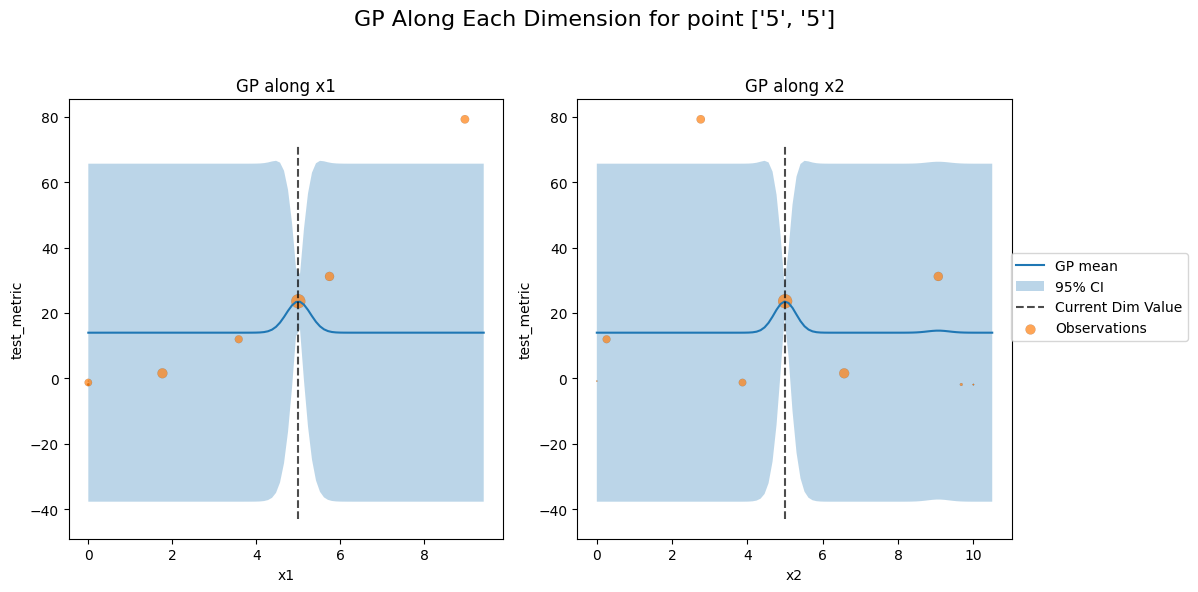

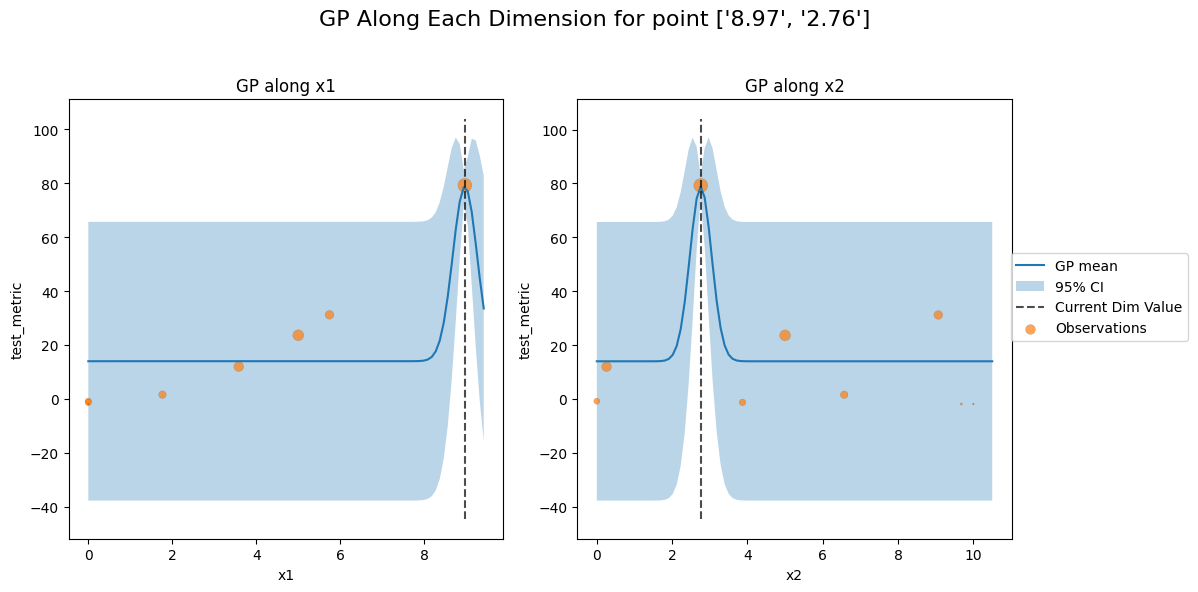

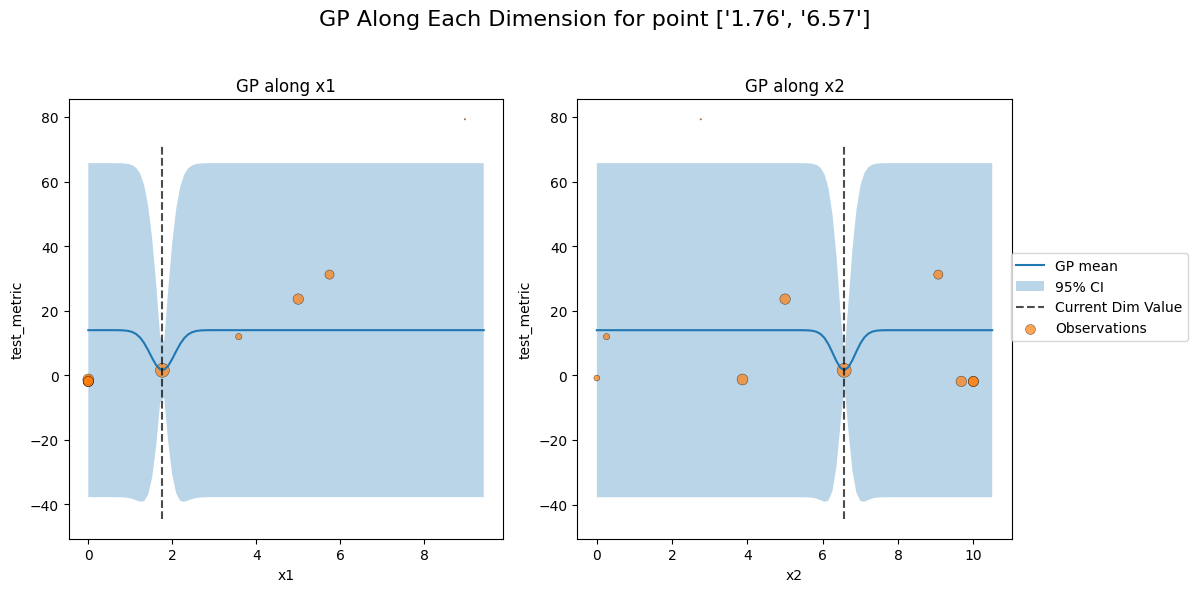

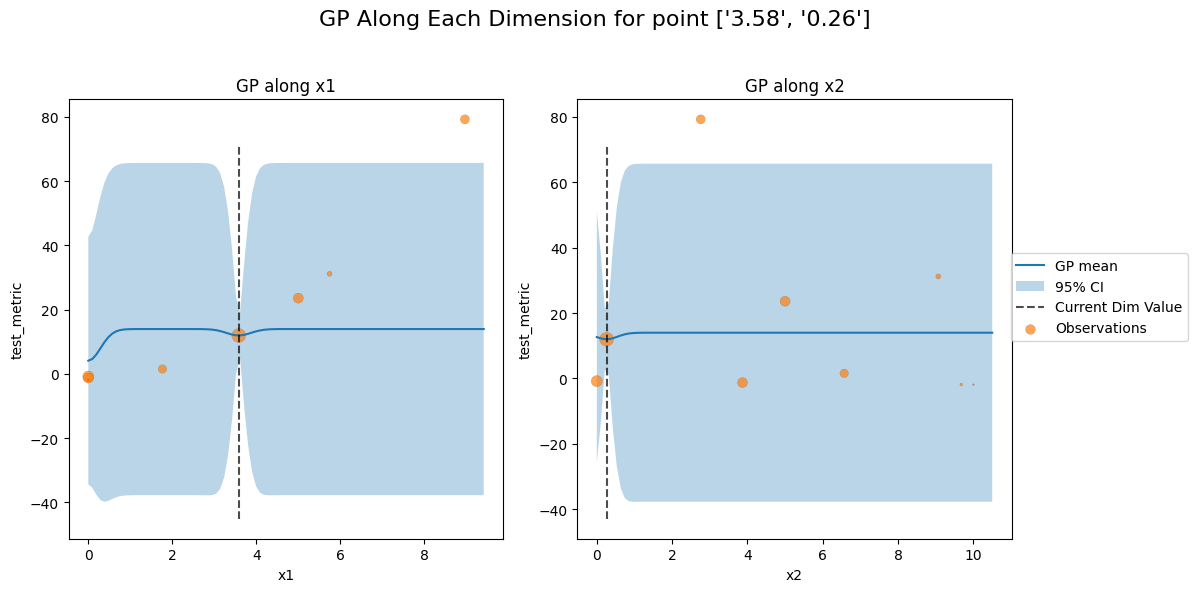

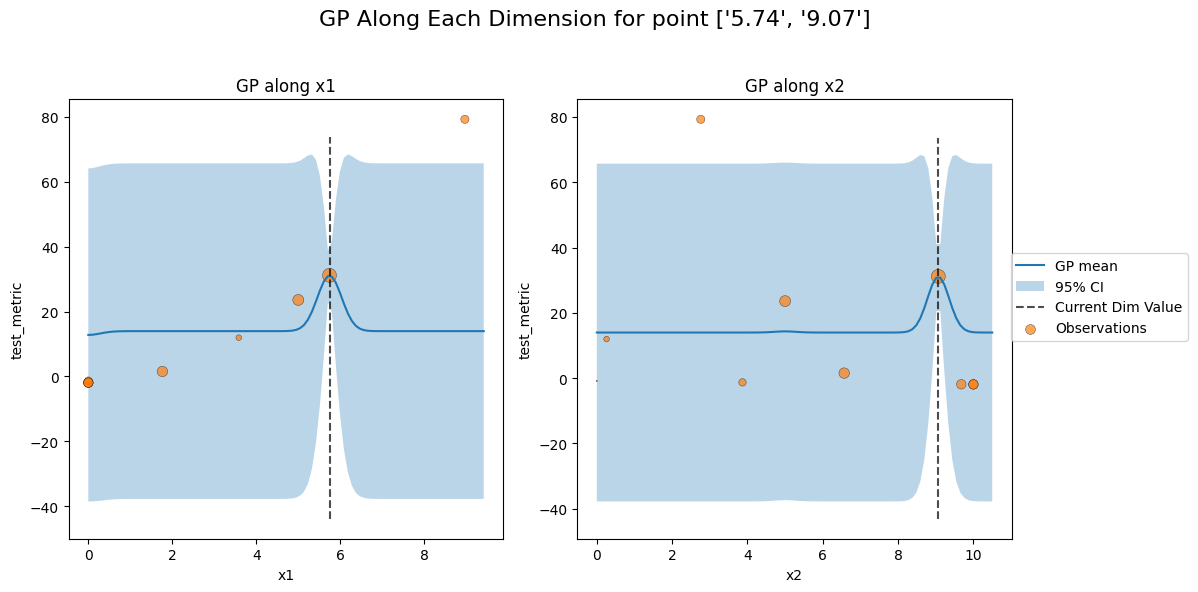

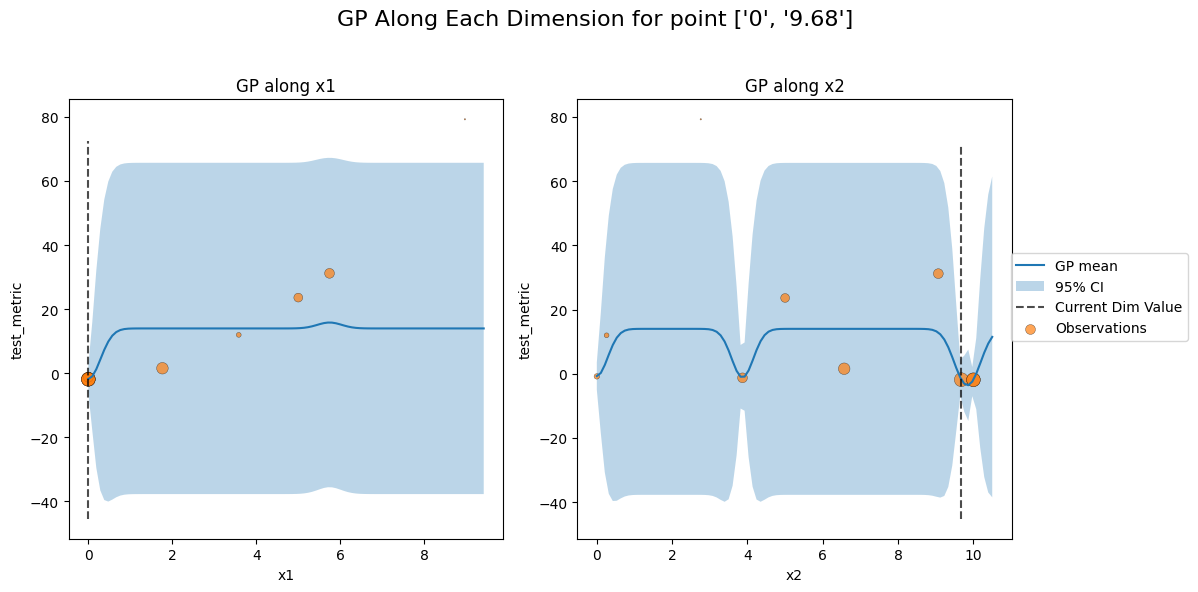

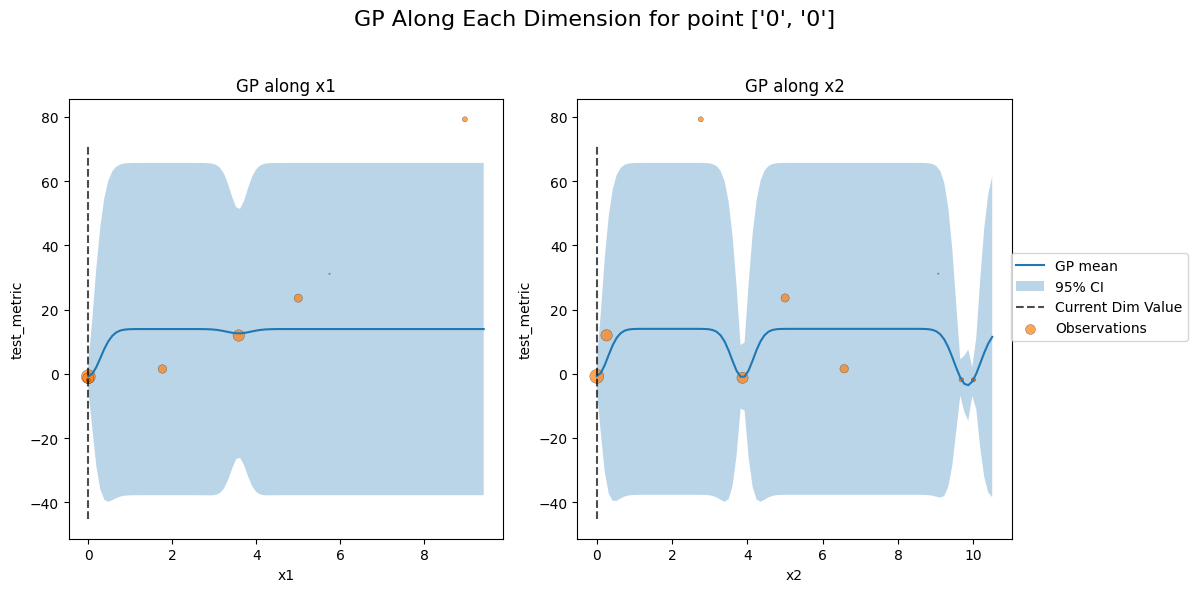

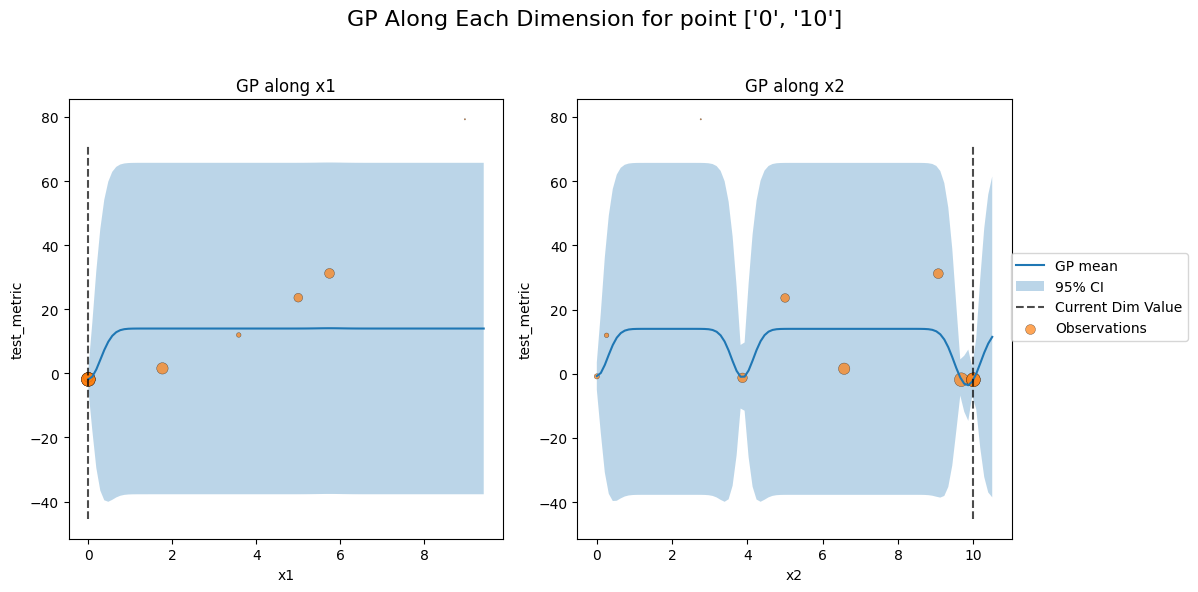

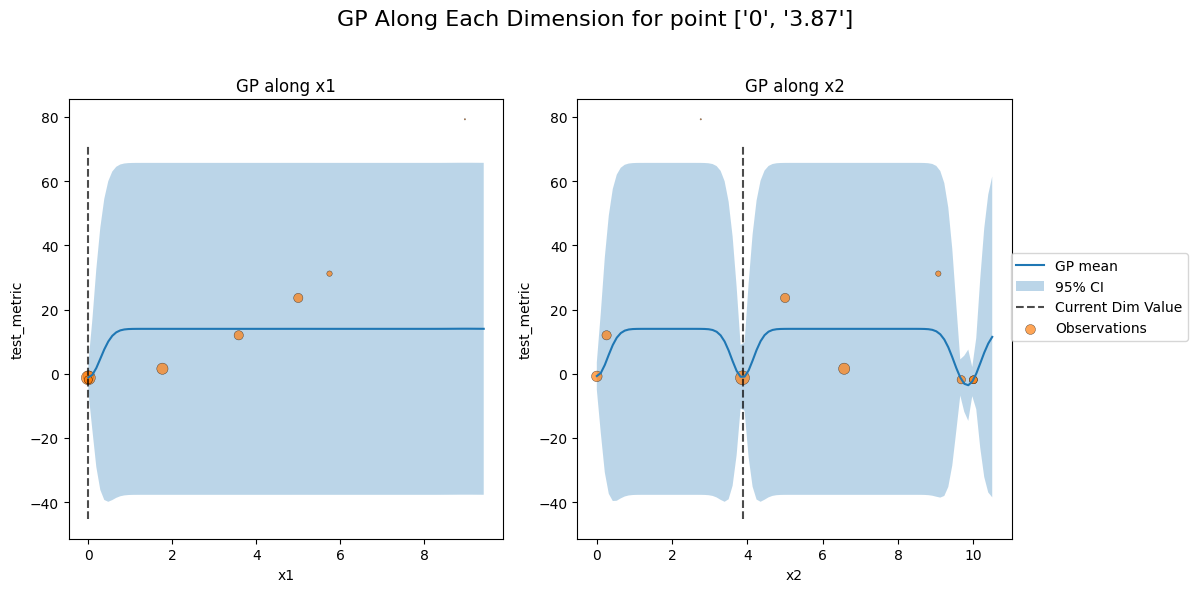

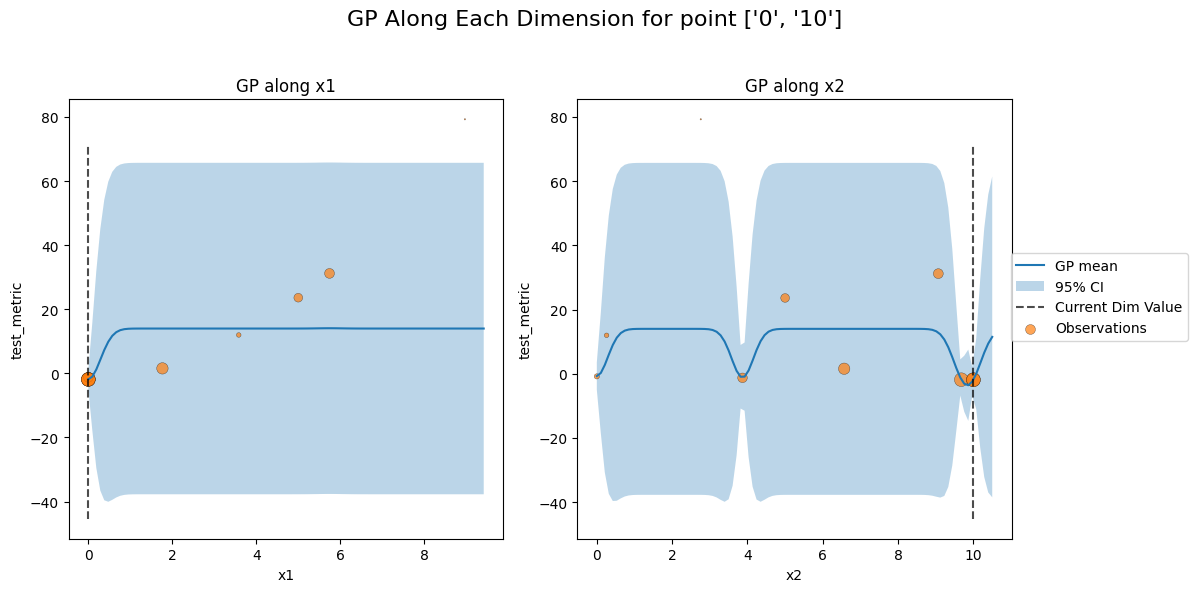

In [ ]:
obs = ax_helper.get_obs_from_client(client, response_col='test_metric')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, ["x1", "x2"], 'test_metric')
for i, trial in obs.iterrows():
    plotter.plot_all(trial[["x1", "x2"]].tolist())